## S&P Sector ETF Anomaly Detection with Isolation Forest

## Master's Dissertation Project

### Abstract
 - This project compares financial performance metrics for holding US Sector Exchange-Traded-Funds (ETFs) after detecting real-time anomalies using the Isolation Forest algorithm over the period 2012-2022. A combination of fundamental and technical data is used to construct the feature set. On average, in most sectors, returns, volatility and risk-adjusted returns all increased following the detection of an anomaly.

In [271]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.ensemble import IsolationForest
import xlwings as xw
from tabula import read_pdf
import random
from tqdm.notebook import tqdm
import warnings
import matplotlib.patches as mpatches

In [64]:
warnings.filterwarnings('ignore')

In [65]:
## display settings

# pd.options.display.max_columns=100
# pd.options.display.max_rows=100

In [66]:
## setting directories

fundamentals_dir = '/Users/lloyd/Documents/Code/Dissertation/fundamentals'
sector_fundamentals_dir = '/Users/lloyd/Documents/Code/Dissertation/sector_fundamentals'
fund_flows_dir = '/Users/lloyd/Documents/Code/Dissertation/fund_flows'

## Data Import & Cleaning

### Reading fundamental data via xlwings and saving as csv

### Reading created fundamental csv data and processing

In [67]:
## extracting, cleaning and inserting fundamental data into dictionary of dataframes

csv_files = [file for file in os.listdir(fundamentals_dir) if file.endswith('.csv')]
fundamentals = {}

In [68]:
for file in csv_files:
    df_name = os.path.splitext(file)[0]
    file_path = os.path.join(fundamentals_dir, file)
    df = pd.read_csv(file_path)
    fundamentals[df_name] = df

In [69]:
for df_name, df in fundamentals.items():
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
    df.set_index(df.columns[0], inplace=True)
    df.rename_axis(None, inplace=True)
    df.sort_index(inplace=True)
    df.rename(columns={'Energy': 'energy',
                       'Materials': 'materials',
                       'Industrials': 'industrials',
                       'Consumer Discretionary': 'consumer_discretionary',
                       'Consumer Staples': 'consumer_staples',
                       'Health Care': 'healthcare',
                       'Financials ': 'financials',
                       'Information Technology': 'technology',
                       'Communication Services': 'communication_services',
                       'Utilities': 'utilities'},
              inplace=True)

In [70]:
fundamentals.keys()

dict_keys(['operating_margin', 'earnings_per_share', 'operating_sales_cont', 'sales_per_share', 'earnings_miss', 'earnings_beat'])

In [71]:
fundamentals['operating_margin'].head()

,energy,materials,industrials,consumer_discretionary,consumer_staples,healthcare,financials,technology,communication_services,utilities
2010-12-31,0.077388,0.075196,0.081920,0.067761,0.064441,0.087159,0.090950,0.172774,0.060414,0.063214
2011-03-31,0.084109,0.099449,0.075373,0.066464,0.061930,0.093681,0.103916,0.162841,0.070381,0.086169
2011-06-30,0.093161,0.101676,0.085404,0.072111,0.064071,0.097268,0.106489,0.166237,0.065152,0.084846
2011-09-30,0.096924,0.078259,0.081694,0.069350,0.064635,0.089667,0.125012,0.156089,0.070971,0.107982
2011-12-31,0.069979,0.040236,0.079651,0.067289,0.062887,0.083469,0.115553,0.176566,0.042868,0.068731


In [72]:
for key, df in fundamentals.items():
    print(f'{key} - {df.isnull().sum().sum()}')

operating_margin - 0
earnings_per_share - 0
operating_sales_cont - 0
sales_per_share - 0
earnings_miss - 0
earnings_beat - 0


### Reading fundamentals by Sector via xlwings and saving csv

In [73]:
# consumer_discretionary = xw.load()
# consumer_discretionary.to_csv(os.path.join(sector_fundamentals_dir, 'consumer_discretionary.csv'))

In [74]:
# consumer_staples = xw.load()
# consumer_staples.to_csv(os.path.join(sector_fundamentals_dir, 'consumer_staples.csv'))

In [75]:
# energy = xw.load()
# energy.to_csv(os.path.join(sector_fundamentals_dir, 'energy.csv'))

In [76]:
# financials = xw.load()
# financials.to_csv(os.path.join(sector_fundamentals_dir, 'financials.csv'))

In [77]:
# healthcare = xw.load()
# healthcare.to_csv(os.path.join(sector_fundamentals_dir, 'healthcare.csv'))

In [78]:
# industrials = xw.load()
# industrials.to_csv(os.path.join(sector_fundamentals_dir, 'industrials.csv'))

In [79]:
# technology = xw.load()
# technology.to_csv(os.path.join(sector_fundamentals_dir, 'technology.csv'))

In [80]:
# materials = xw.load()
# materials.to_csv(os.path.join(sector_fundamentals_dir, 'materials.csv'))

In [81]:
# communication_services = xw.load()
# communication_services.to_csv(os.path.join(sector_fundamentals_dir, 'communication_services.csv'))

In [82]:
# utilities = xw.load()
# utilities.to_csv(os.path.join(sector_fundamentals_dir, 'utilities.csv'))

### Reading created fundamental by sector csv and formatting

In [83]:
## extracting, cleaning and inserting fundamental data into dictionary of dataframes

csv_files = [file for file in os.listdir(sector_fundamentals_dir) if file.endswith('.csv')]
sector_fundamentals = {}

In [84]:
for file in csv_files:
    df_name = os.path.splitext(file)[0]
    file_path = os.path.join(sector_fundamentals_dir, file)
    df = pd.read_csv(file_path)
    sector_fundamentals[df_name] = df

In [85]:
for df_name, df in sector_fundamentals.items():
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
    df.set_index(df.columns[0], inplace=True)
    df.rename_axis(None, inplace=True)
    df.sort_index(inplace=True)

In [86]:
sector_fundamentals.keys()

dict_keys(['materials', 'industrials', 'technology', 'consumer_discretionary', 'utilities', 'healthcare', 'energy', 'consumer_staples', 'financials', 'communication_services'])

In [87]:
sector_fundamentals['communication_services'].head()

,earnings_per_share,sales_per_share,operating_margin,operating_sales_cont,earnings_beat,earnings_miss
2008-03-31,1.89,NaN,NaN,NaN,NaN,NaN
2008-06-30,2.20,NaN,NaN,NaN,NaN,NaN
2008-09-30,1.93,NaN,NaN,NaN,NaN,NaN
2008-12-31,0.99,NaN,NaN,NaN,NaN,NaN
2009-03-31,1.78,NaN,NaN,NaN,NaN,NaN


In [88]:
for key, df in sector_fundamentals.items():
    print(f'{key} - {df.isnull().sum().sum()}')

materials - 66
industrials - 66
technology - 66
consumer_discretionary - 66
utilities - 66
healthcare - 66
energy - 66
consumer_staples - 66
financials - 66
communication_services - 66


### Reading PDF fund flows & transforming to csv

In [89]:
# # reading pdf files and converting to csv
# # file in files must be changed manually

# files = ['xly_vox.pdf', 'xly_vox1.pdf']
# dfs = []

In [90]:
# for file in files:
#     df = read_pdf(os.path.join(fund_flows_dir, file), pages='all')
#     combined = pd.concat(df)
#     dfs.append(combined)
#     df = pd.concat(dfs)
#     df.to_csv(os.path.join(fund_flows_dir, 'xly_vox.csv'), index=False)

### Reading CSV fund flows and cleaning into useable dataframe

In [91]:
## formatting initial fund flow dataframe

fund_flows = pd.read_csv(os.path.join(fund_flows_dir, 'xle_xlb.csv'), index_col='Date')
fund_flows = fund_flows.drop(columns='Aggregate Net Flows')

In [92]:
## merging rest of fund flow data

csv_files = ['xlk_xlu.csv',
             'xlp_xlf.csv',
             'xlv_xli.csv',
             'xly_vox.csv']

In [93]:
for file in csv_files:
    df = pd.read_csv(os.path.join(fund_flows_dir, file), index_col='Date')
    df = df.drop(columns='Aggregate Net Flows')
    fund_flows = fund_flows.merge(df, how='outer', left_on='Date', right_on='Date')

In [94]:
## getting date index aligned with other data

fund_flows.index = pd.to_datetime(fund_flows.index)
fund_flows.index = fund_flows.index + pd.offsets.MonthEnd(0)

In [95]:
## cleaning data and casting correct dtype

fund_flows = fund_flows.replace(',', '', regex=True)
fund_flows = fund_flows.astype({col: float for col in fund_flows.columns})

In [96]:
## renaming columns

fund_flows.columns = [col[:-10] for col in fund_flows.columns]
fund_flows = fund_flows.rename_axis(None)

In [97]:
ticker_sector_dict = {'XLE': 'energy',
                      'XLB': 'materials',
                      'XLK': 'technology',
                      'XLU': 'utilities',
                      'XLP': 'consumer_staples',
                      'XLF': 'financials',
                      'XLV': 'healthcare',
                      'XLI': 'industrials',
                      'XLY': 'consumer_discretionary',
                      'VOX': 'communication_services',
                      'SPY': 's&p_500'}

In [98]:
for col in fund_flows.columns:
    if col[:3] in ticker_sector_dict:
        new_col = ticker_sector_dict[col[:3]] + col[3:]
        fund_flows.rename(columns={col: new_col}, inplace=True)

In [99]:
fund_flows.keys()

Index(['energy', 'materials', 'technology', 'utilities', 'consumer_staples',
       'financials', 'healthcare', 'industrials', 'consumer_discretionary',
       'communication_services'],
      dtype='object')

In [100]:
fund_flows['communication_services'].head()

2012-04-30   -56.804
2012-05-31    12.761
2012-06-30    19.667
2012-07-31    76.151
2012-08-31    -0.129
Name: communication_services, dtype: float64

In [101]:
for key, df in fund_flows.items():
    print(f'{key} - {df.isnull().sum().sum()}')

energy - 0
materials - 0
technology - 0
utilities - 0
consumer_staples - 0
financials - 0
healthcare - 0
industrials - 0
consumer_discretionary - 0
communication_services - 0


### Downloading tickers

In [102]:
symbols = ['VOX',
           'XLY',
           'XLP',
           'XLE',
           'XLF',
           'XLV',
           'XLI',
           'XLB',
           'XLK',
           'XLU',
           'SPY']

startDate = '2012-04-01'
endDate = '2022-12-31'
interval = '1mo'

tickers = {}

for symbol in symbols:
    data = yf.download(symbol, start=startDate, end=endDate, interval=interval)
    tickers[symbol] = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [103]:
## cleaning price & volume data

for key, df in tickers.items():
    df.index = df.index + pd.offsets.MonthEnd(0)
    df.drop(columns=['Open', 'Close'], inplace=True)
    df.rename(columns={'Adj Close': 'close',
                       'Volume': 'volume',
                       'High': 'high',
                       'Low': 'low'}, inplace=True)
    df['range'] = df.apply(lambda row: row['high'] - row['low'], axis=1)
    df.rename_axis(None, inplace=True)

In [104]:
## matching keys to sectors

updated_tickers = {ticker_sector_dict[key]: value for key, value in tickers.items()}
tickers = updated_tickers

In [105]:
tickers.keys()

dict_keys(['communication_services', 'consumer_discretionary', 'consumer_staples', 'energy', 'financials', 'healthcare', 'industrials', 'materials', 'technology', 'utilities', 's&p_500'])

In [106]:
tickers['communication_services'].head()

,high,low,close,volume,range
2012-04-30,65.459999,62.540001,50.878391,1210900,2.919998
2012-05-31,65.570000,62.380001,50.399227,919900,3.189999
2012-06-30,68.000000,62.549999,53.266384,871700,5.450001
2012-07-31,71.290001,65.660004,55.662224,2130100,5.629997
2012-08-31,72.379997,69.860001,55.638676,1123300,2.519997


## Creating combined dataframes & rolling dataframes

In [107]:
## creating new dictionary including fund flows in the price data

technicals = {}
for ticker in tickers:
    if ticker in fund_flows.columns:
        column_name = 'net_flows'
        technicals[ticker] = tickers[ticker].assign(**{column_name: fund_flows[ticker]})

In [108]:
## creating new dictionary with resampled technical data to match fundamentals

technicals_Q = {}

for key, df in technicals.items():
    df_quarterly = pd.DataFrame()
    df_quarterly['close'] = df['close'].resample('Q').last()
    df_quarterly['high'] = df['high'].resample('Q').max()
    df_quarterly['low'] = df['low'].resample('Q').min()
    df_quarterly['volume'] = df['volume'].resample('Q').sum()
    df_quarterly['range'] = df_quarterly['high'] - df_quarterly['low']
    df_quarterly['net_flows'] = df['net_flows'].resample('Q').sum()
    
    technicals_Q[key] = df_quarterly

In [109]:
## creating monthly change technicals

# technicals_change = {}

# for key, df in technicals.items():
#     df_change = df.pct_change().dropna()
#     df_change.drop(columns=['High', 'Low'], inplace=True)
#     technicals_change[key] = df_change

In [110]:
# creating quarterly change technicals

technicals_Q_change = {}

for key, df in technicals_Q.items():
    df_change = df.pct_change().dropna()
    technicals_Q_change[key] = df_change

In [111]:
## creating combined technical and fundamental for Q data

q_data = {}

for key in technicals_Q:
    if key in sector_fundamentals:
        q_data[key] = technicals_Q[key].merge(sector_fundamentals[key], left_index=True, right_index=True)
        

In [112]:
q_data['communication_services'].head()

,close,high,low,volume,range,net_flows,earnings_per_share,sales_per_share,operating_margin,operating_sales_cont,earnings_beat,earnings_miss
2012-06-30,53.266384,68.000000,62.380001,3002500,5.619999,-24.376,1.74,28.952899,0.079094,0.032192,0.625000,0.125000
2012-09-30,58.953571,76.519997,65.660004,4147500,10.859993,76.473,1.88,29.139065,0.071725,0.032566,0.500000,0.250000
2012-12-31,54.994534,76.470001,67.059998,4337600,9.410004,-56.940,-3.42,30.257294,-0.095845,0.031388,0.250000,0.375000
2013-03-31,60.289917,74.430000,69.730003,3566100,4.699997,-35.350,2.06,29.929454,0.070165,0.032605,0.625000,0.250000
2013-06-30,64.160179,81.989998,74.070000,6410300,7.919998,45.549,1.85,30.527483,0.070756,0.031870,0.285714,0.428571


In [113]:
## creating quarterly change in combined data

q_change = {}

for key, df in q_data.items():
    df.drop(columns=['high', 'low'], inplace=True)
    df = df.pct_change()
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df['price'] = q_data[key]['close']
    df.dropna(inplace=True)
    q_change[key] = df

In [114]:
q_change['communication_services'].head()

,close,volume,range,net_flows,earnings_per_share,sales_per_share,operating_margin,operating_sales_cont,earnings_beat,earnings_miss,price
2012-09-30,0.106769,0.381349,0.932383,-4.137225,0.080460,0.006430,-0.093167,0.011608,-0.200000,1.000000,58.953571
2012-12-31,-0.067155,0.045835,-0.133517,-1.744577,-2.819149,0.038376,-2.336279,-0.036171,-0.500000,0.500000,54.994534
2013-03-31,0.096289,-0.177863,-0.500532,-0.379171,-1.602339,-0.010835,-1.732070,0.038776,1.500000,-0.333333,60.289917
2013-06-30,0.064194,0.797566,0.685107,-2.288515,-0.101942,0.019981,0.008422,-0.022533,-0.542857,0.714286,64.160179
2013-09-30,0.023571,-0.646740,-0.198231,-1.358757,0.140541,-0.049868,0.213281,-0.110872,0.166667,-0.222222,65.672508


In [115]:
## rolling dataframes for sectors to process as if in real-time

window_size = 12

rolling_dfs = {}

for key, df in q_change.items():
    rolling_dict = {}
    for i in range(len(df) - window_size + 1):
        start_idx = df.index[i]
        end_idx = df.index[i + window_size - 1]
        rolling_df = df.loc[start_idx:end_idx].copy()
        rolling_dict[end_idx] = rolling_df
    rolling_dfs[key] = rolling_dict

In [116]:
rolling_dfs['communication_services'].keys()

dict_keys([Timestamp('2015-06-30 00:00:00'), Timestamp('2015-09-30 00:00:00'), Timestamp('2015-12-31 00:00:00'), Timestamp('2016-03-31 00:00:00'), Timestamp('2016-09-30 00:00:00'), Timestamp('2016-12-31 00:00:00'), Timestamp('2017-03-31 00:00:00'), Timestamp('2017-06-30 00:00:00'), Timestamp('2017-09-30 00:00:00'), Timestamp('2017-12-31 00:00:00'), Timestamp('2018-03-31 00:00:00'), Timestamp('2018-06-30 00:00:00'), Timestamp('2018-09-30 00:00:00'), Timestamp('2018-12-31 00:00:00'), Timestamp('2019-03-31 00:00:00'), Timestamp('2019-06-30 00:00:00'), Timestamp('2019-09-30 00:00:00'), Timestamp('2019-12-31 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-06-30 00:00:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-03-31 00:00:00'), Timestamp('2021-06-30 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-12-31 00:00:00'), Timestamp('2022-03-31 00:00:00'), Timestamp('2022-06-30 00:00:00'), Timestamp('2022-09-30 00:00:00'), Tim

In [136]:
rolling_dfs['communication_services'][pd.Timestamp('2018-12-31 00:00:00')]

,close,volume,range,net_flows,earnings_per_share,sales_per_share,operating_margin,operating_sales_cont,earnings_beat,earnings_miss,price,decision_function,anomaly
2015-12-31,0.095660,-0.267513,-0.183388,-1.684491,0.690763,0.050792,0.151312,0.037922,-0.250000,0.000000,73.016960,0.086515,NaN
2016-03-31,0.113401,2.047917,0.740181,7.213180,-0.332542,-0.045482,-0.152192,0.010883,0.333333,-1.000000,81.297180,-0.001576,1.0
2016-09-30,-0.034732,0.375673,0.118377,-1.244245,0.637584,0.008274,0.343055,-0.010845,-0.500000,0.000000,83.740105,0.098539,NaN
2016-12-31,0.070262,-0.313667,0.461693,1.201848,-0.012295,0.027557,-0.049276,-0.003965,-0.500000,2.000000,89.623863,0.078262,NaN
2017-03-31,-0.045270,0.019380,-0.226897,-0.806424,0.020747,-0.085273,0.162086,-0.070339,-1.000000,-0.166667,85.566597,0.084114,NaN
2017-06-30,-0.023761,-0.333026,-0.281891,5.200534,0.178862,0.013554,0.023169,-0.002423,0.000000,-0.500000,83.533470,0.120312,NaN
2017-09-30,0.012891,0.126207,-0.162734,-2.111163,-0.179310,0.012884,-0.033876,-0.009279,0.000000,0.000000,84.610283,0.123209,NaN
2017-12-31,-0.003053,0.713996,0.807122,-4.651380,4.739496,0.064296,-0.334744,-0.020366,-0.333333,1.666667,84.351990,0.026015,NaN
2018-03-31,-0.071076,-0.346658,-0.119048,-0.774900,-0.761347,-0.072070,0.994241,-0.038328,1.000000,-0.500000,78.356628,0.035429,NaN
2018-06-30,0.024079,-0.315260,-0.372787,-0.531216,0.015337,-0.064471,0.161216,-0.020458,0.000000,0.000000,80.243370,0.131698,NaN


## Data Exploration

In [118]:
## Exploring returns

columns = []

for key, df in q_change.items():
    if 'close' in df.columns:
        columns.append(df['close'].rename(f'{key}'))
        
returns = pd.concat(columns, axis=1)

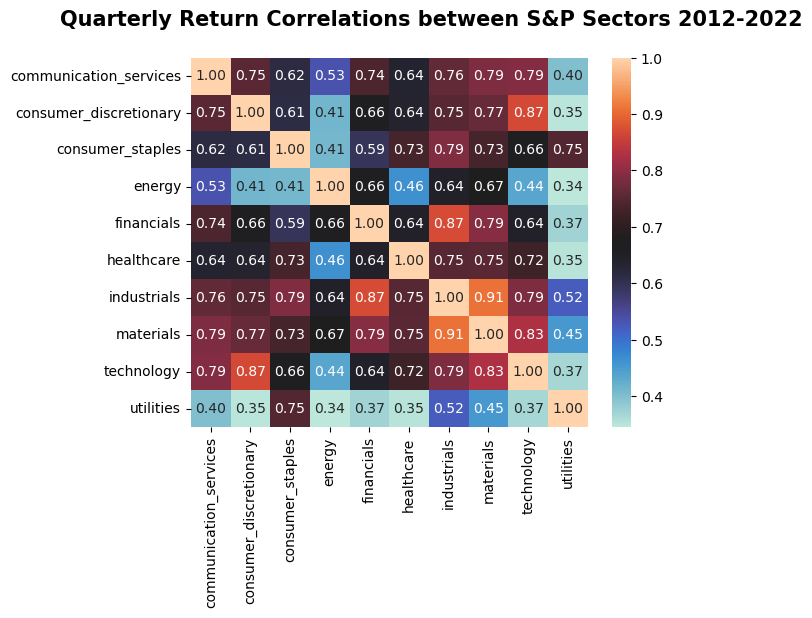

In [119]:
# sns.pairplot(returns, diag_kind='kde', kind='reg', plot_kws={'line_kws': {'color': 'pink'}})
sns.heatmap(returns.corr(), annot=True, fmt='.2f', cmap='icefire')

plt.suptitle("Quarterly Return Correlations between S&P Sectors 2012-2022", fontsize=15, fontweight='bold')
    
plt.show()

In [120]:
# columns = []

# for key, df in q_change.items():
#     if 'range' in df.columns:
#         columns.append(df['range'].rename(f'{key}'))
        
# range = pd.concat(columns, axis=1)

In [121]:
# sns.pairplot(range)

In [122]:
# columns = []

# for key, df in sector_fundamentals.items():
#     if 'earnings_per_share' in df.columns:
#         columns.append(df['earnings_per_share'].rename(f'{key}'))
        
# eps = pd.concat(columns, axis=1)

In [123]:
# sns.pairplot(eps, kind='reg', plot_kws={'line_kws': {'color': 'pink'}})

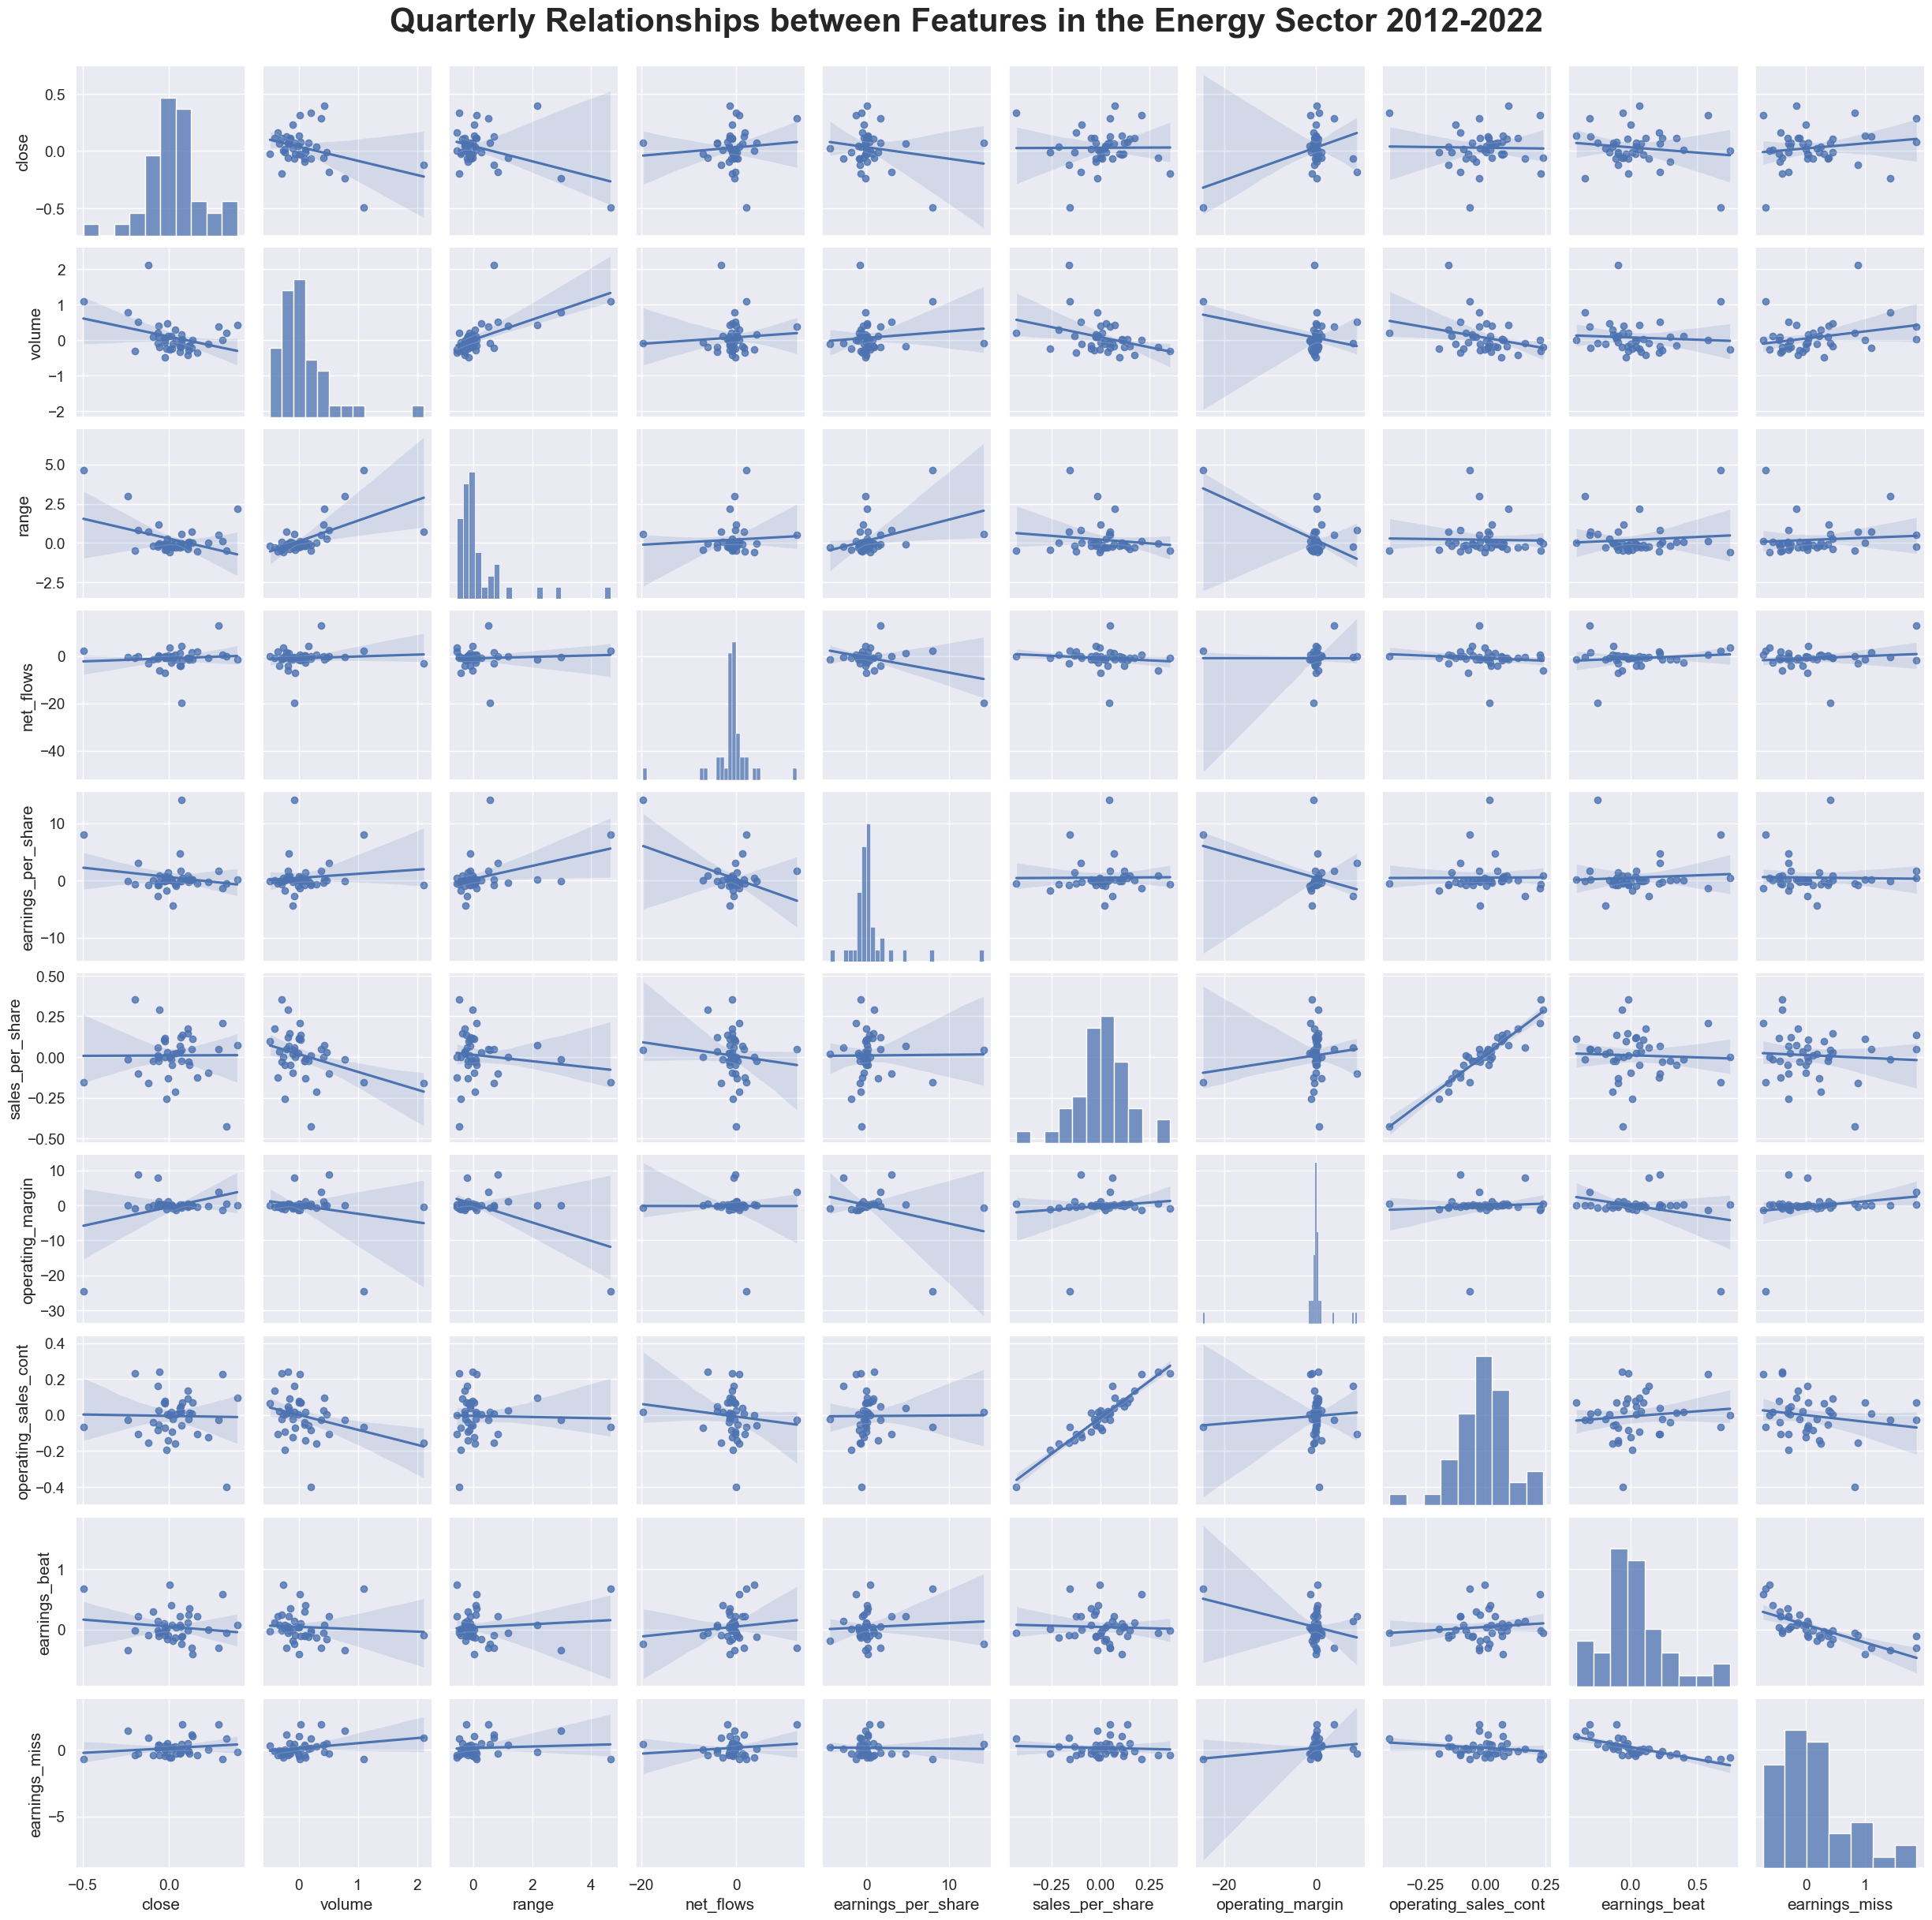

In [124]:
sns.set(style='white')
sns.set(font_scale=1.25)

sns.pairplot(q_change['energy'].drop(columns='price'), kind='reg')

plt.suptitle("Quarterly Relationships between Features in the Energy Sector 2012-2022", fontweight='bold', fontsize=30)
plt.subplots_adjust(top=0.95)
plt.show()

In [125]:
# sns.set(style="ticks")

# for key, df in q_change.items():
#     plt.figure(figsize=(10, 18))
#     num_cols = df.shape[1] - 1  # Subtract 1 to exclude the "price" column
#     num_rows = int((num_cols + 1) / 2)  # Calculate the number of rows for subplots
    
#     for i, column in enumerate(df.columns):
#         if column != 'price':
#             plt.subplot(num_rows, 2, i+1)
#             sns.histplot(data=df[column])
#             plt.title(f'{column}')
#             plt.xlabel(column)
#             plt.ylabel('Frequency')
#             plt.xticks(rotation=45)
    
#     plt.suptitle(f'Histograms of Variables for {key}')
#     plt.tight_layout()
#     plt.show()

In [126]:
# ax = sns.heatmap(fundamentals['operating_sales_cont'].pct_change().corr(), annot=True, fmt='.2f', cmap='icefire')

# # Rotate and align the x-axis labels
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# # Display the plot
# plt.show()

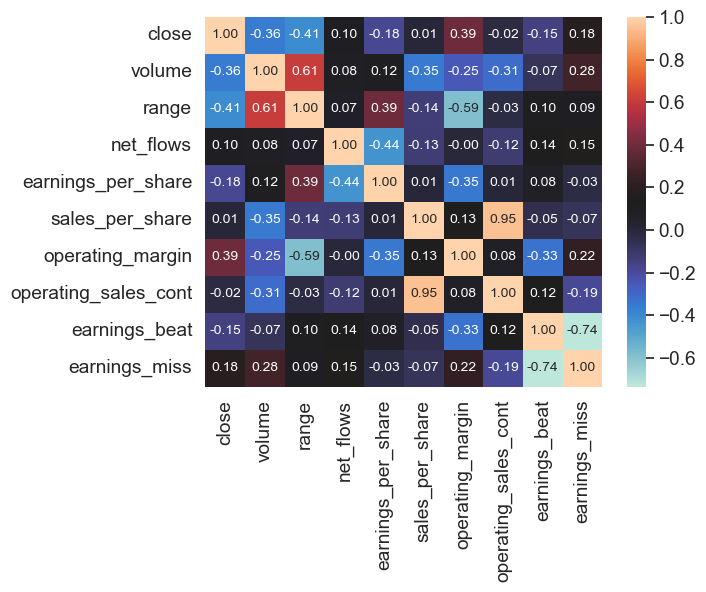

In [127]:
sns.heatmap(q_change['energy'].drop(columns='price').corr(), annot=True, fmt='.2f', cmap='icefire', annot_kws={"fontsize": 10})
plt.show()

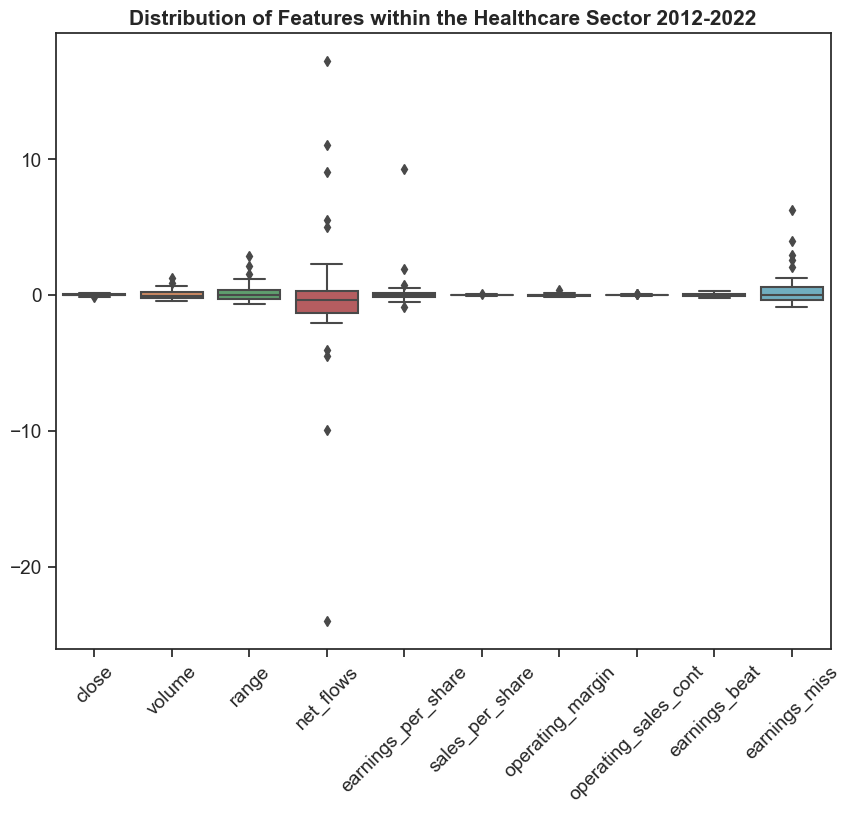

In [128]:
sns.set_style('ticks')
plt.figure(figsize=(10, 8))
plt.xticks(rotation=45)
sns.boxplot(q_change['healthcare'].drop(columns='price'))
plt.title("Distribution of Features within the Healthcare Sector 2012-2022", fontsize=15, fontweight='bold')
plt.show()

In [129]:
# sns.set(style="ticks")

# for key, df in q_change.items():
#     plt.figure(figsize=(12, 12))
#     data = df.drop(columns=['price'])
#     showfliers = False if 'net_flows' in data.columns else True
#     sns.boxplot(data=data, showfliers=showfliers)
#     plt.title(f'Boxplot of Variables for {key}')
#     plt.xticks(rotation=45)
#     plt.show()

## Model Building

In [130]:
## setting params

contamination = 0.1
estimators = 200
max_features = 1
random = 42

In [131]:
## performing iForest on all rolling dfs

for key, rolling_dict in tqdm(rolling_dfs.items()):
    for date, df in tqdm(rolling_dict.items()):
        X = df.drop('price', axis=1)
        X['price'] = df['price']
        model = IsolationForest(contamination=contamination, n_estimators=estimators, max_features=max_features, random_state=random, verbose=False)
        model.fit(X)
        decision_function = model.decision_function(X)
        anomalies = model.predict(X)
        df['decision_function'] = np.nan
        df['anomaly'] = np.nan
        df.loc[X.index, 'decision_function'] = decision_function
        df.loc[X.index, 'anomaly'] = anomalies
        df['anomaly'] = df['anomaly'].map({-1: 1})
        rolling_dict[date] = df

    rolling_dfs[key] = rolling_dict

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [132]:
## creating dataframes where anomaly is found on last row (in real-time)

anomaly_dfs = {}

for key in rolling_dfs.keys():
    anomaly_dfs[key] = pd.DataFrame()
    rolling_dict = rolling_dfs[key]
    for df_key, df in rolling_dict.items():
        last_row = df.iloc[[-1]]
        if last_row['anomaly'].values[0] == 1:
            anomaly_dfs[key] = pd.concat([anomaly_dfs[key], last_row])

In [133]:
anomaly_dfs['technology']

,close,volume,range,net_flows,earnings_per_share,sales_per_share,operating_margin,operating_sales_cont,earnings_beat,earnings_miss,price,decision_function,anomaly
2017-03-31,0.107222,-0.206756,0.429363,0.348240,-0.244019,-0.114569,-0.065642,-0.090031,0.035714,0.000000,49.368671,-0.000351,1.0
2017-12-31,0.085930,-0.002428,0.280487,0.016250,-0.750000,0.195018,0.185249,0.120666,-0.034989,1.029851,59.902920,-0.000200,1.0
2018-03-31,0.026801,0.650890,0.646032,1.583253,3.494845,-0.094747,-0.021912,-0.067021,0.054723,-0.838164,61.508358,-0.044245,1.0
2018-12-31,-0.174430,0.837318,1.575756,3.804287,0.009476,0.091823,-0.059955,0.070392,-0.094184,1.228856,58.862343,-0.042798,1.0
2020-03-31,-0.120408,1.280849,1.321119,1.483347,-0.318436,-0.130870,-0.092620,-0.034303,-0.082079,-0.103713,77.671021,-0.005505,1.0
2021-12-31,0.166460,0.467381,1.281391,22.771163,0.049493,0.109348,0.036722,0.038706,-0.054135,1.434211,171.116699,-0.004922,1.0


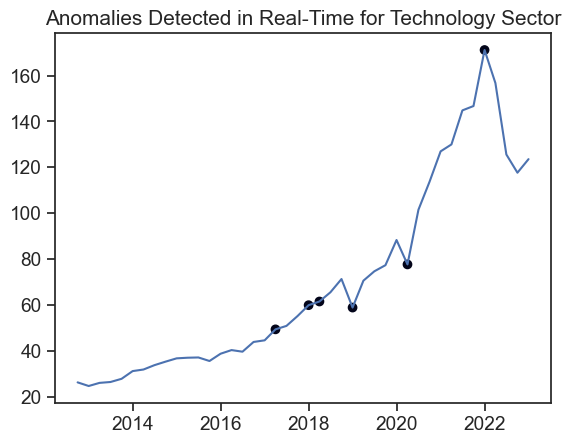

In [137]:
plt.plot(q_change['technology']['price'])
plt.scatter(x=anomaly_dfs['technology'].index, y=anomaly_dfs['technology']['price'], c=anomaly_dfs['technology']['anomaly'])
plt.title('Anomalies Detected in Real-Time for Technology Sector')
plt.show()

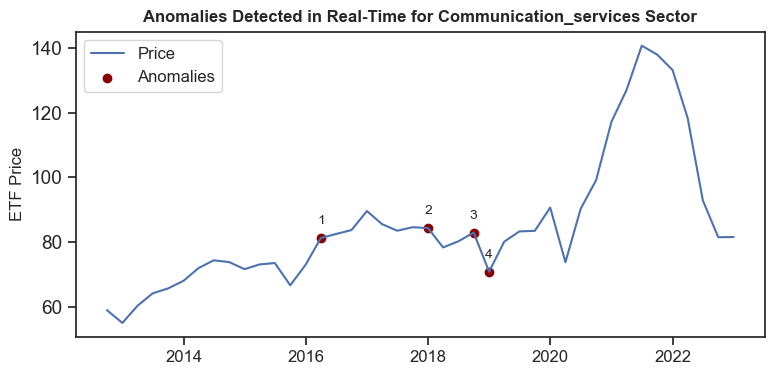

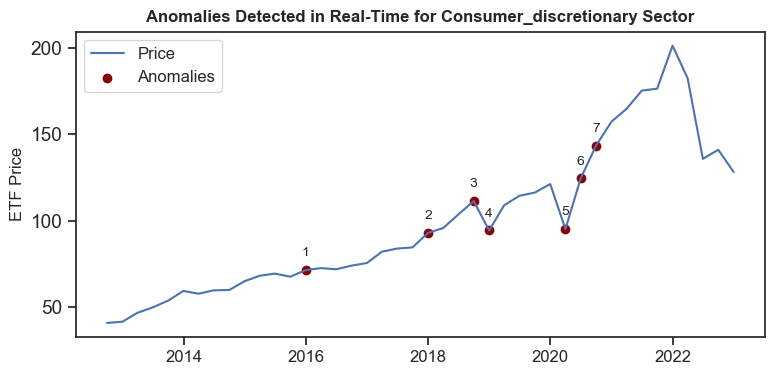

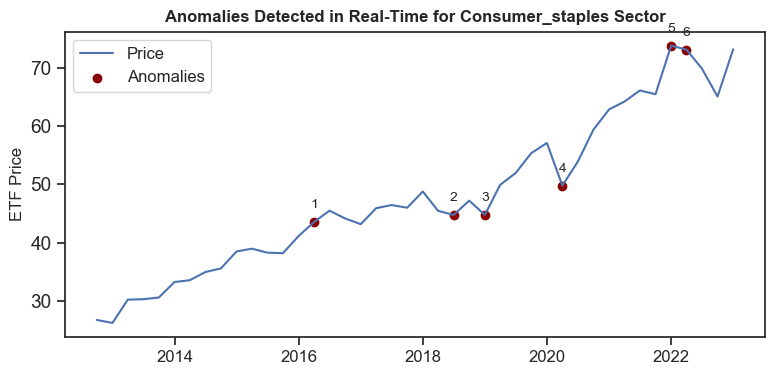

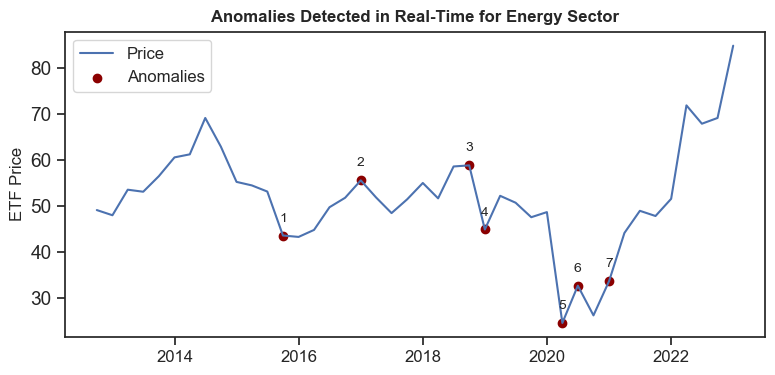

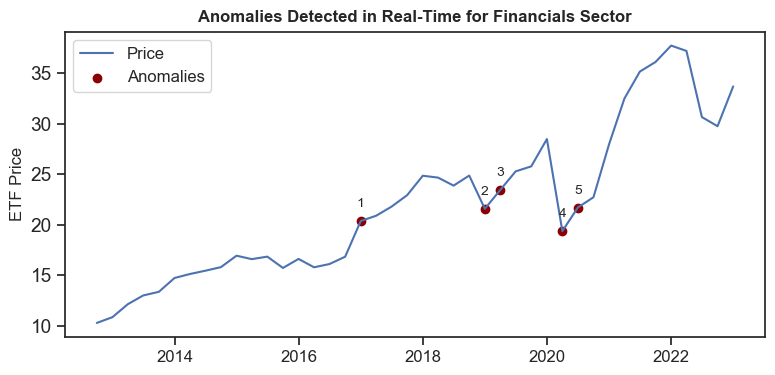

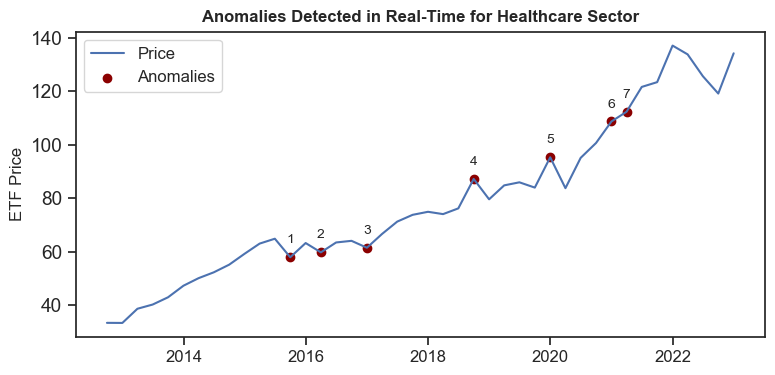

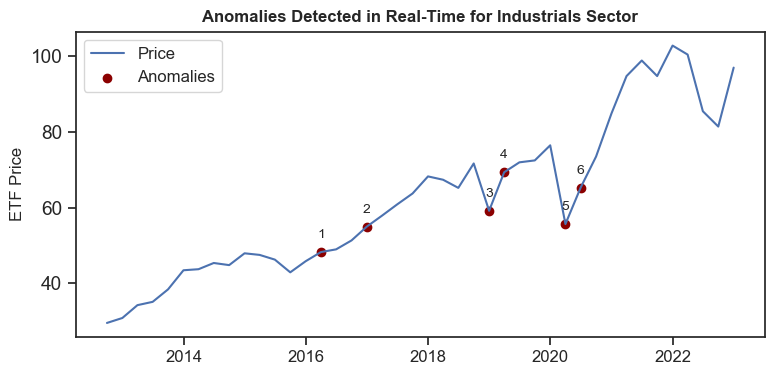

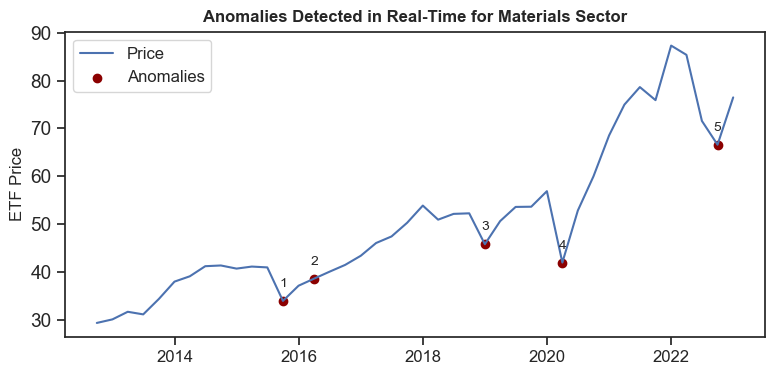

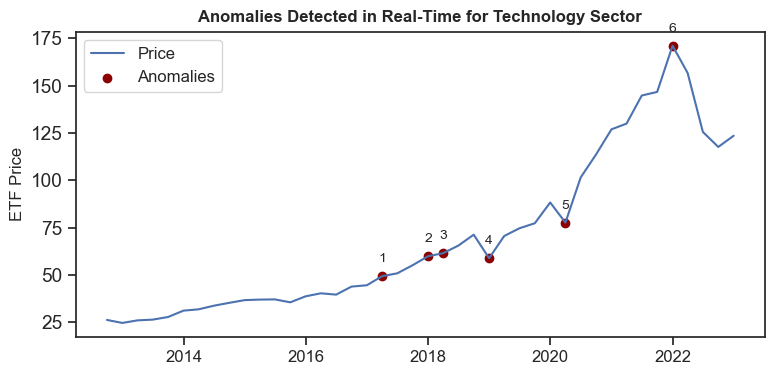

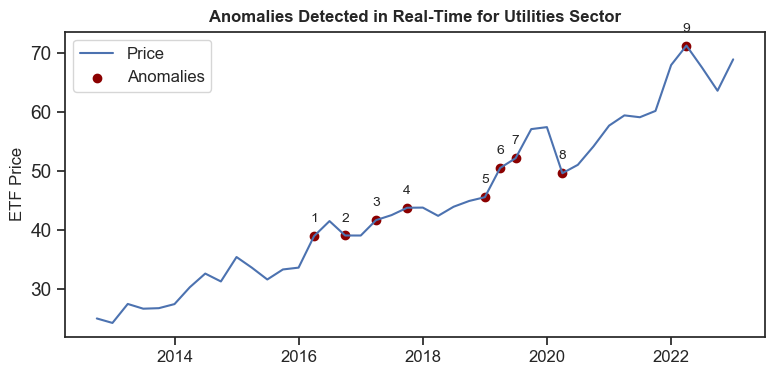

In [171]:
for sector in anomaly_dfs:
    plt.figure(figsize=(8, 4))

    plt.plot(q_change[sector]['price'])

    plt.scatter(
        x=anomaly_dfs[sector].index,
        y=anomaly_dfs[sector]['price'],
        c=(139/255, 0, 0),  # Set the color for anomalies to red
        marker='o' if 'anomaly' in anomaly_dfs[sector] else None
    )

    plt.title(f'Anomalies Detected in Real-Time for {sector.capitalize()} Sector', fontsize=12, fontweight='bold', pad=7)
    plt.ylabel('ETF Price', fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(['Price', 'Anomalies'], fontsize=12)
    
    anomaly_count = 0
    for i, value in enumerate(anomaly_dfs[sector]['anomaly']):
        if value == 1:
            anomaly_count += 1
            plt.annotate(f'{anomaly_count}', (anomaly_dfs[sector].index[i], anomaly_dfs[sector]['price'][i]),
                         textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

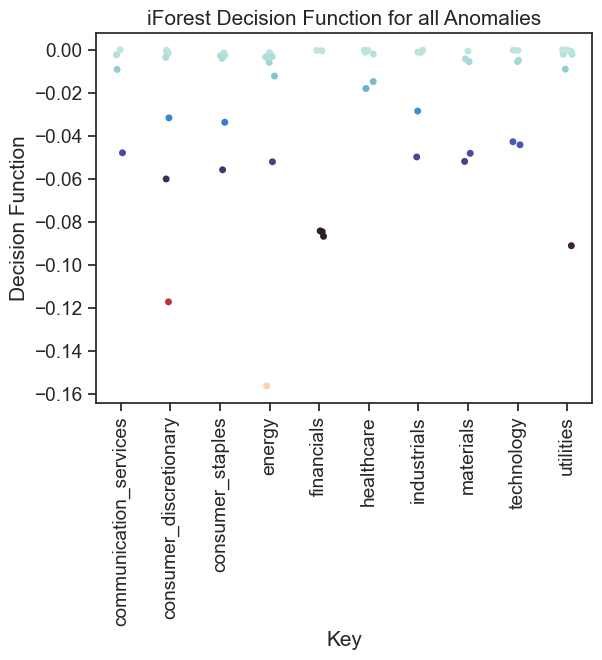

In [173]:
## Decision Function Plot for all anomalies

dfs = []

for key, df in anomaly_dfs.items():
    df['Key'] = key
    dfs.append(df)

df_combined = pd.concat(dfs)

sns.stripplot(data=df_combined, x='Key', y='decision_function', hue='decision_function', palette='icefire_r', legend=False)

plt.xticks(rotation=90)

plt.ylabel('Decision Function')
plt.title('iForest Decision Function for all Anomalies')

# for i, row in df_combined.iterrows():
#     if row['decision_function'] < -0.05:
#         plt.text(row['Key'], row['decision_function'], row.name.strftime('%Y-%m'), ha='center', va='bottom')

plt.show()

In [174]:
df_combined

,close,volume,range,net_flows,earnings_per_share,sales_per_share,operating_margin,operating_sales_cont,earnings_beat,earnings_miss,price,decision_function,anomaly,Key
2016-03-31,0.113401,2.047917,0.740181,7.213180,-0.332542,-0.045482,-0.152192,0.010883,0.333333,-1.000000,81.297180,-0.047940,1.0,communication_services
2017-12-31,-0.003053,0.713996,0.807122,-4.651380,4.739496,0.064296,-0.334744,-0.020366,-0.333333,1.666667,84.351990,-0.002334,1.0,communication_services
2018-09-30,0.033833,0.557529,-0.301634,-10.490206,-0.371601,-0.468612,0.022962,1.606404,0.200000,-0.640000,82.958221,-0.000065,1.0,communication_services
2018-12-31,-0.146052,1.528149,2.831916,0.029771,0.125000,0.114380,-0.081476,0.095645,-0.200000,1.333333,70.842003,-0.009178,1.0,communication_services
2015-12-31,0.056485,0.005483,-0.428474,-55.776440,0.192308,0.086789,-0.050249,0.062386,0.113208,-0.142857,71.340225,-0.000238,1.0,consumer_discretionary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,0.014164,0.590873,0.572840,-7.207961,-1.239741,-0.076064,-0.506307,-0.087430,-0.291667,1.750000,45.550064,-0.002158,1.0,utilities
2019-03-31,0.108543,-0.282526,0.182104,-1.022463,-4.495495,-0.007881,0.774670,0.042311,-0.147059,0.035714,50.494183,-0.000876,1.0,utilities
2019-06-30,0.032701,0.040795,-0.373174,-22.538597,-0.219072,-0.120953,-0.063969,-0.149260,-0.214286,0.181818,52.145416,-0.000126,1.0,utilities
2020-03-31,-0.135829,0.441023,6.578087,-4.032341,-0.361386,0.006467,0.093253,0.118232,-0.285714,1.000000,49.604050,-0.009026,1.0,utilities


In [175]:
anomaly_dfs['consumer_discretionary']['decision_function'] < -0.1

2015-12-31    False
2017-12-31    False
2018-09-30    False
2018-12-31    False
2020-03-31     True
2020-06-30    False
2020-09-30    False
Name: decision_function, dtype: bool

## Results

In [176]:
## creating dictionary of dfs with returns following 1yr period after anomaly

yearly_deviations_post_anomaly = {}

for key in anomaly_dfs.keys():
    yearly_deviations_post_anomaly[key] = pd.DataFrame(columns=['1yr_return'])
    
    anomaly_df = anomaly_dfs[key]
    q_df = q_data[key]
    
    for date in anomaly_df.index:
        if date in q_df.index and (date + pd.DateOffset(years=1)) in q_df.index:
            current_price = q_df.loc[date]['close']
            next_year_price = q_df.loc[date + pd.DateOffset(years=1)]['close']
            returns = (next_year_price - current_price) / current_price
            df = pd.DataFrame({'1yr_return': returns}, index=[date])
            yearly_deviations_post_anomaly[key] = pd.concat([yearly_deviations_post_anomaly[key], df])
        else:
            df = pd.DataFrame({'1yr_return': float('NaN')}, index=[date])
            yearly_deviations_post_anomaly[key] = pd.concat([yearly_deviations_post_anomaly[key], df])

In [177]:
## checking for nulls

for key, df in yearly_deviations_post_anomaly.items():
    nan_indices = pd.isna(df['1yr_return'])
    nan_dates = df.index[nan_indices].tolist()
    print(f"NaN values in {key}: {nan_dates}")

NaN values in communication_services: []
NaN values in consumer_discretionary: []
NaN values in consumer_staples: [Timestamp('2022-03-31 00:00:00')]
NaN values in energy: []
NaN values in financials: []
NaN values in healthcare: []
NaN values in industrials: []
NaN values in materials: [Timestamp('2022-09-30 00:00:00')]
NaN values in technology: []
NaN values in utilities: [Timestamp('2022-03-31 00:00:00')]


In [178]:
yearly_deviations_post_anomaly['communication_services']

,1yr_return
2016-03-31,0.052516
2017-12-31,-0.160162
2018-09-30,0.006409
2018-12-31,0.280356


In [179]:
## creating dictionary of dfs with returns of quarter after anomaly

quarterly_deviations_post_anomaly = {}

for key in anomaly_dfs.keys():
    quarterly_deviations_post_anomaly[key] = pd.DataFrame(columns=['1Q_return'])
    
    anomaly_df = anomaly_dfs[key]
    q_df = q_data[key]
    
    for date in anomaly_df.index:
        if date in q_df.index and (date + pd.offsets.QuarterEnd()) in q_df.index:
            current_price = q_df.loc[date]['close']
            next_Q_price = q_df.loc[date + pd.offsets.QuarterEnd()]['close']
            returns = (next_Q_price - current_price) / current_price
            df = pd.DataFrame({'1Q_return': returns}, index=[date])
            quarterly_deviations_post_anomaly[key] = pd.concat([quarterly_deviations_post_anomaly[key], df])
        else:
            df = pd.DataFrame({'1Q_return': float('NaN')}, index=[date])
            quarterly_deviations_post_anomaly[key] = pd.concat([quarterly_deviations_post_anomaly[key], df])

In [180]:
## checking for nulls

for key, df in quarterly_deviations_post_anomaly.items():
    nan_indices = pd.isna(df['1Q_return'])
    nan_dates = df.index[nan_indices].tolist()
    print(f"NaN values in {key}: {nan_dates}")

NaN values in communication_services: []
NaN values in consumer_discretionary: []
NaN values in consumer_staples: []
NaN values in energy: []
NaN values in financials: []
NaN values in healthcare: []
NaN values in industrials: []
NaN values in materials: []
NaN values in technology: []
NaN values in utilities: []


In [181]:
quarterly_deviations_post_anomaly['communication_services']

,1Q_return
2016-03-31,0.067112
2017-12-31,-0.071076
2018-09-30,-0.146052
2018-12-31,0.131133


In [182]:
## creating dictionary of dfs with returns of 2 quarters after anomaly

q2_deviations_post_anomaly = {}

for key in anomaly_dfs.keys():
    q2_deviations_post_anomaly[key] = pd.DataFrame(columns=['6mo_return'])
    
    anomaly_df = anomaly_dfs[key]
    q_df = q_data[key]
    
    for date in anomaly_df.index:
        if date in q_df.index and (date + pd.offsets.QuarterEnd(2)) in q_df.index:
            current_price = q_df.loc[date]['close']
            next_2Q_price = q_df.loc[date + pd.offsets.QuarterEnd(2)]['close']
            returns = (next_2Q_price - current_price) / current_price
            df = pd.DataFrame({'6mo_return': returns}, index=[date])
            q2_deviations_post_anomaly[key] = pd.concat([q2_deviations_post_anomaly[key], df])
        else:
            df = pd.DataFrame({'6mo_return': float('NaN')}, index=[date])
            q2_deviations_post_anomaly[key] = pd.concat([q2_deviations_post_anomaly[key], df])

In [183]:
## checking for nulls

for key, df in q2_deviations_post_anomaly.items():
    nan_indices = pd.isna(df['6mo_return'])
    nan_dates = df.index[nan_indices].tolist()
    print(f"NaN values in {key}: {nan_dates}")

NaN values in communication_services: []
NaN values in consumer_discretionary: []
NaN values in consumer_staples: []
NaN values in energy: []
NaN values in financials: []
NaN values in healthcare: []
NaN values in industrials: []
NaN values in materials: [Timestamp('2022-09-30 00:00:00')]
NaN values in technology: []
NaN values in utilities: []


In [184]:
q2_deviations_post_anomaly['communication_services']

,6mo_return
2016-03-31,0.030049
2017-12-31,-0.048708
2018-09-30,-0.034072
2018-12-31,0.176097


In [185]:
## creating dataframe for returns and standard deviations

yearly_deviations = pd.DataFrame(index=q_data.keys())

In [186]:
for key, df in q_data.items():
    returns = (df['close'].resample('A').last() - df['close'].resample('A').first()) / df['close'].resample('A').first()
    return_avg = returns.mean()
    std = returns.std()
    yearly_deviations.loc[key, 'average_1yr_return'] = return_avg
    yearly_deviations.loc[key, '1yr_std_returns'] = std

In [187]:
for key, df in yearly_deviations_post_anomaly.items():
    average_deviation = df['1yr_return'].mean()
    std = df['1yr_return'].std()
    yearly_deviations.loc[key, 'average_1yr_return_post_anomaly'] = average_deviation
    yearly_deviations.loc[key, '1yr_std_returns_post_anomaly'] = std

In [234]:
yearly_deviations['return_diff'] = yearly_deviations['average_1yr_return_post_anomaly'] / yearly_deviations['average_1yr_return'] - 1

In [238]:
yearly_deviations = yearly_deviations * 100

In [189]:
# averages = yearly_deviations.mean()
# averages_df = pd.DataFrame(averages).T
# averages_df.index = ['AVERAGE']
# yearly_deviations = pd.concat([yearly_deviations, averages_df])

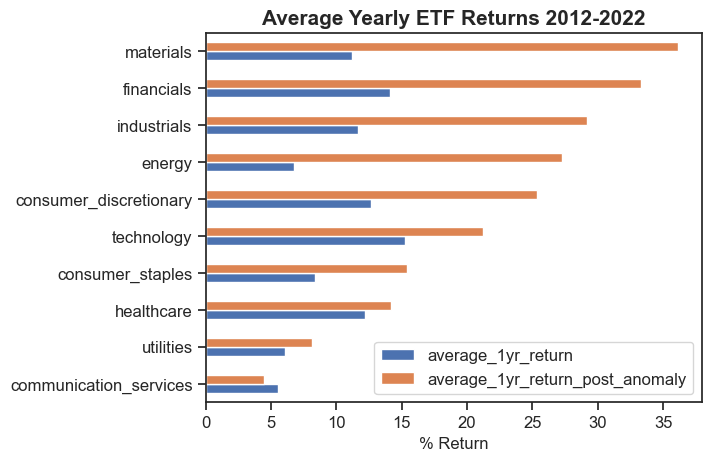

In [287]:
yearly_deviations.sort_values(by='average_1yr_return_post_anomaly').plot.barh(y=['average_1yr_return',
                                                                                 'average_1yr_return_post_anomaly'], fontsize=12)
plt.title("Average Yearly ETF Returns 2012-2022", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.xlabel("% Return", fontsize=12)
plt.show()

In [242]:
yearly_deviations

,average_1yr_return,1yr_std_returns,average_1yr_return_post_anomaly,1yr_std_returns_post_anomaly,return_diff
communication_services,5.508804,21.624018,4.477970,18.168617,-18.712473
consumer_discretionary,12.625712,22.890043,25.332467,25.640754,100.641883
consumer_staples,8.322335,8.658009,15.427426,13.175371,85.373769
energy,6.716103,17.642090,27.226134,35.051595,305.385866
financials,14.071264,16.581462,33.293670,34.315546,136.607525
healthcare,12.178143,9.850634,14.190866,9.698693,16.527335
industrials,11.635173,17.333548,29.184252,30.604895,150.827833
materials,11.189903,20.725458,36.155108,28.511183,223.104742
technology,15.233495,21.869431,21.192085,34.461385,39.115052
utilities,6.078325,8.001909,8.144071,10.319646,33.985452


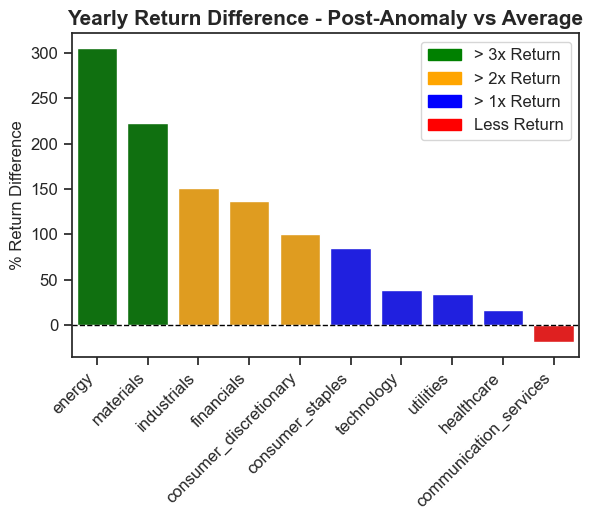

In [369]:
sorted_deviations = yearly_deviations.sort_values(by='return_diff', ascending=False)

plt.figure(figsize=(7, 4))

color_palette = []
legend_info = []

for val in sorted_deviations['return_diff']:
    if val > 200:
        color = 'green'
        label = '> 3x Return'
    elif 100 <= val <= 200:
        color = 'orange'
        label = '> 2x Return'
    elif 0 <= val < 100:
        color = 'blue'
        label = '> 1x Return'
    else:
        color = 'red'
        label = 'Less Return'
    
    color_palette.append(color)
    legend_info.append((color, label))

sns.barplot(x=sorted_deviations.index, y=sorted_deviations['return_diff'], palette=color_palette)

unique_legend_info = list(set(legend_info))
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in unique_legend_info]

plt.legend(handles=legend_patches, fontsize=12, loc='upper right')
plt.tight_layout()
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.title("Yearly Return Difference - Post-Anomaly vs Average", fontsize=15, fontweight='bold')
plt.ylabel("% Return Difference", fontsize=12)
plt.show()

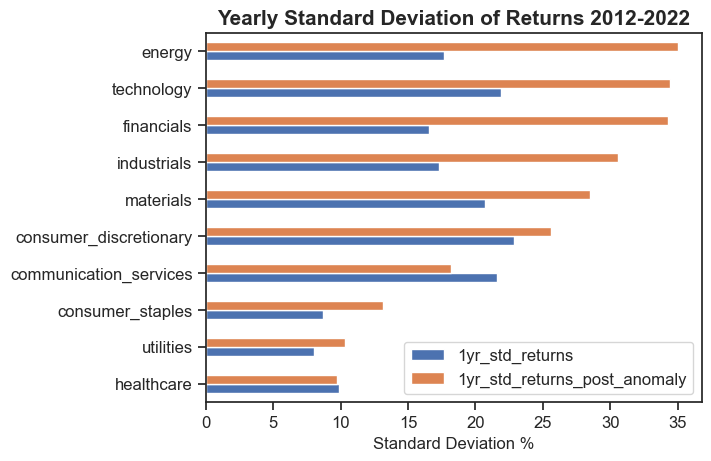

In [372]:
yearly_deviations.sort_values(by='1yr_std_returns_post_anomaly').plot.barh(y=['1yr_std_returns',
                                                                                 '1yr_std_returns_post_anomaly'], fontsize=12)
plt.title("Yearly Standard Deviation of Returns 2012-2022", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.xlabel("Standard Deviation %", fontsize=12)
plt.show()

In [192]:
## creating sharpe ratios (risk-adjusted returns)

years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
rfr = [0.0235, 0.0254, 0.0214, 0.0184, 0.0233, 0.0291, 0.0214, 0.0089, 0.0145, 0.0295]

In [193]:
risk_free_rate = pd.DataFrame({'risk_free_rate': rfr}, index=years)

In [194]:
risk_free_rate

,risk_free_rate
2013,0.0235
2014,0.0254
2015,0.0214
2016,0.0184
2017,0.0233
2018,0.0291
2019,0.0214
2020,0.0089
2021,0.0145
2022,0.0295


In [195]:
av_rfr = risk_free_rate.mean()

In [196]:
av_rfr

risk_free_rate    0.02154
dtype: float64

In [339]:
y_sharpe_ratios = pd.DataFrame(index=yearly_deviations.index)

In [340]:
for sector in yearly_deviations.index:
    returns = yearly_deviations.loc[sector, 'average_1yr_return']
    std = yearly_deviations.loc[sector, '1yr_std_returns']
    sharpe = (returns - av_rfr) / std
    y_sharpe_ratios.loc[sector, '1yr_sharpe_ratio'] = sharpe.item()

In [341]:
for sector in yearly_deviations.index:
    returns = yearly_deviations.loc[sector, 'average_1yr_return_post_anomaly']
    std = yearly_deviations.loc[sector, '1yr_std_returns_post_anomaly']
    sharpe = (returns - av_rfr) / std
    y_sharpe_ratios.loc[sector, '1y_sharpe_ratio_post_anomaly'] = sharpe.item()

In [342]:
y_sharpe_ratios['difference'] = (sharpe_ratios['av_sharpe_ratio_post_anomaly'] / sharpe_ratios['av_sharpe_ratio'] - 1) * 100

In [350]:
y_sharpe_ratios = y_sharpe_ratios.round(2)

In [355]:
y_sharpe_ratios.to_excel('1yrsharpe.xlsx')

In [377]:
q2_sharpe_ratios = pd.DataFrame(index=q2_deviations.index)

In [378]:
for sector in q2_deviations.index:
    returns = q2_deviations.loc[sector, 'average_6mo_return']
    std = q2_deviations.loc[sector, '6mo_std_returns']
    sharpe = (returns - av_rfr) / std
    q2_sharpe_ratios.loc[sector, '6mo_sharpe_ratio'] = sharpe.item()

In [379]:
for sector in q2_deviations.index:
    returns = q2_deviations.loc[sector, 'average_6mo_return_post_anomaly']
    std = q2_deviations.loc[sector, '6mo_std_returns_post_anomaly']
    sharpe = (returns - av_rfr) / std
    q2_sharpe_ratios.loc[sector, '6mo_sharpe_ratio_post_anomaly'] = sharpe.item()

In [381]:
q2_sharpe_ratios.to_excel('6mosharpe.xlsx')

In [382]:
q1_sharpe_ratios = pd.DataFrame(index=q_deviations.index)

In [383]:
for sector in q_deviations.index:
    returns = q_deviations.loc[sector, 'average_1Q_return']
    std = q_deviations.loc[sector, '1Q_std_returns']
    sharpe = (returns - av_rfr) / std
    q1_sharpe_ratios.loc[sector, '1Q_sharpe_ratio'] = sharpe.item()

In [384]:
for sector in q_deviations.index:
    returns = q_deviations.loc[sector, 'average_1Q_return_post_anomaly']
    std = q_deviations.loc[sector, '1Q_std_returns_post_anomaly']
    sharpe = (returns - av_rfr) / std
    q1_sharpe_ratios.loc[sector, '1Q_sharpe_ratio_post_anomaly'] = sharpe.item()

In [396]:
q1_sharpe_ratios.to_excel('1qsharpe.xlsx')

In [202]:
## creating dataframe for quarterly returns and standard deviations

q_deviations = pd.DataFrame(index=q_data.keys())

In [203]:
for key, df in q_data.items():
    returns = df['close'].pct_change()
    deviation = returns.mean()
    std = returns.std()
    q_deviations.loc[key, 'average_1Q_return'] = deviation
    q_deviations.loc[key, '1Q_std_returns'] = std

In [204]:
for key, df in quarterly_deviations_post_anomaly.items():
    average_deviation = df['1Q_return'].mean()
    std = df['1Q_return'].std()
    q_deviations.loc[key, 'average_1Q_return_post_anomaly'] = average_deviation
    q_deviations.loc[key, '1Q_std_returns_post_anomaly'] = std

In [205]:
# averages = q_deviations.mean()
# averages_df = pd.DataFrame(averages).T
# averages_df.index = ['AVERAGE']
# q_deviations = pd.concat([q_deviations, averages_df])

In [206]:
q_deviations

,average_1Q_return,1Q_std_returns,average_1Q_return_post_anomaly,1Q_std_returns_post_anomaly
communication_services,0.014429,0.092235,-0.004721,0.126483
consumer_discretionary,0.034022,0.096204,0.086547,0.143688
consumer_staples,0.026795,0.058418,0.040593,0.058750
energy,0.028933,0.158326,0.042395,0.231597
financials,0.035019,0.094585,0.071606,0.036911
healthcare,0.037252,0.067313,0.020609,0.087923
industrials,0.033636,0.090990,0.095932,0.070027
materials,0.028665,0.093264,0.129059,0.082952
technology,0.043481,0.092102,0.090709,0.139609
utilities,0.026075,0.062480,0.033176,0.050059


In [393]:
q_deviations = q_deviations *100

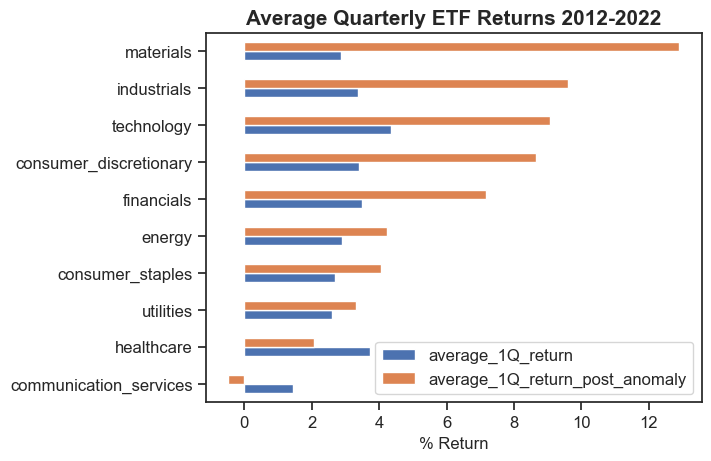

In [394]:
q_deviations.sort_values(by='average_1Q_return_post_anomaly').plot.barh(y=['average_1Q_return',
                                                                                 'average_1Q_return_post_anomaly'], fontsize=12)
plt.title("Average Quarterly ETF Returns 2012-2022", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.xlabel("% Return", fontsize=12)
plt.show()

In [399]:
q_deviations['return_diff'] = (q_deviations['average_1Q_return_post_anomaly'] / q_deviations['average_1Q_return'] - 1)*100

In [400]:
q_deviations

,average_1Q_return,1Q_std_returns,average_1Q_return_post_anomaly,1Q_std_returns_post_anomaly,return_diff
communication_services,1.44,9.22,-0.47,12.65,-132.72
consumer_discretionary,3.40,9.62,8.65,14.37,154.38
consumer_staples,2.68,5.84,4.06,5.88,51.49
energy,2.89,15.83,4.24,23.16,46.53
financials,3.50,9.46,7.16,3.69,104.48
healthcare,3.73,6.73,2.06,8.79,-44.68
industrials,3.36,9.10,9.59,7.00,185.20
materials,2.87,9.33,12.91,8.30,350.23
technology,4.35,9.21,9.07,13.96,108.62
utilities,2.61,6.25,3.32,5.01,27.23


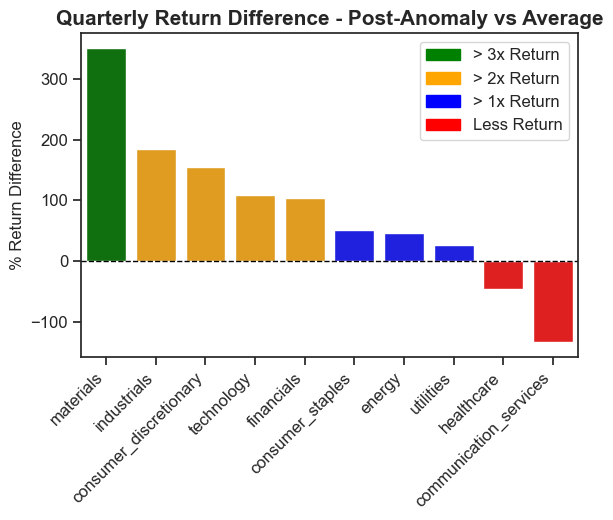

In [401]:
sorted_q_deviations = q_deviations.sort_values(by='return_diff', ascending=False)

plt.figure(figsize=(7, 4))

color_palette = []
legend_info = []

for val in sorted_q_deviations['return_diff']:
    if val > 200:
        color = 'green'
        label = '> 3x Return'
    elif 100 <= val <= 200:
        color = 'orange'
        label = '> 2x Return'
    elif 0 <= val < 100:
        color = 'blue'
        label = '> 1x Return'
    else:
        color = 'red'
        label = 'Less Return'
    
    color_palette.append(color)
    legend_info.append((color, label))

sns.barplot(x=sorted_q_deviations.index, y=sorted_q_deviations['return_diff'], palette=color_palette)

unique_legend_info = list(set(legend_info))
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in unique_legend_info]

plt.legend(handles=legend_patches, fontsize=12, loc='upper right')
plt.tight_layout()
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.title("Quarterly Return Difference - Post-Anomaly vs Average", fontsize=15, fontweight='bold')
plt.ylabel("% Return Difference", fontsize=12)
plt.show()

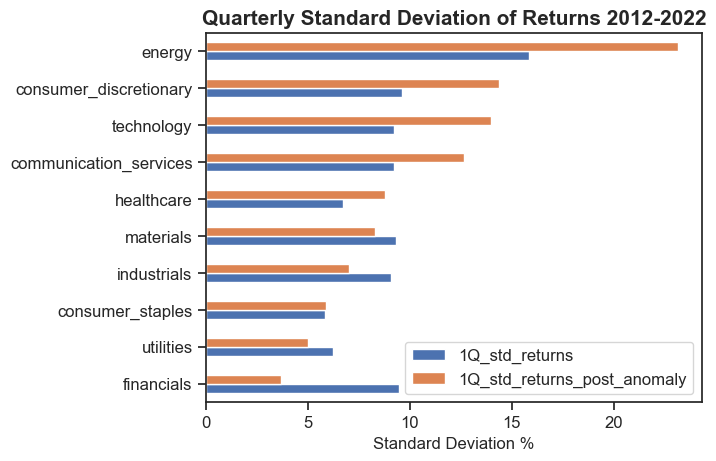

In [395]:
q_deviations.sort_values(by='1Q_std_returns_post_anomaly').plot.barh(y=['1Q_std_returns',
                                                                                 '1Q_std_returns_post_anomaly'], fontsize=12)
plt.title("Quarterly Standard Deviation of Returns 2012-2022", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.xlabel("Standard Deviation %", fontsize=12)
plt.show()

In [209]:
## creating 6-month deviations

q2_deviations = pd.DataFrame(index=q_data.keys())

In [210]:
for key, df in q_data.items():
    returns = (df['close'].resample('2Q').last() - df['close'].resample('2Q').first()) / df['close'].resample('2Q').first()
    return_avg = returns.mean()
    std = returns.std()
    q2_deviations.loc[key, 'average_6mo_return'] = return_avg
    q2_deviations.loc[key, '6mo_std_returns'] = std


In [211]:
for key, df in q2_deviations_post_anomaly.items():
    average_deviation = df['6mo_return'].mean()
    std = df['6mo_return'].std()
    q2_deviations.loc[key, 'average_6mo_return_post_anomaly'] = average_deviation
    q2_deviations.loc[key, '6mo_std_returns_post_anomaly'] = std

In [359]:
q2_deviations = q2_deviations *100

In [363]:
q2_deviations['return_diff'] = (q2_deviations['average_6mo_return_post_anomaly'] / q2_deviations['average_6mo_return'] - 1) * 100

In [364]:
q2_deviations

,average_6mo_return,6mo_std_returns,average_6mo_return_post_anomaly,6mo_std_returns_post_anomaly,return_diff
communication_services,2.35,9.58,3.08,10.27,30.96
consumer_discretionary,3.65,10.83,17.63,17.92,382.73
consumer_staples,3.32,5.11,3.40,11.92,2.33
energy,4.88,12.97,6.72,19.51,37.76
financials,5.49,9.16,16.09,8.47,192.90
healthcare,4.76,6.14,6.42,6.71,34.86
industrials,4.29,8.77,17.53,12.03,308.60
materials,4.70,8.97,20.31,15.65,331.95
technology,4.68,10.71,13.94,24.05,197.90
utilities,2.49,5.09,4.98,8.18,99.70


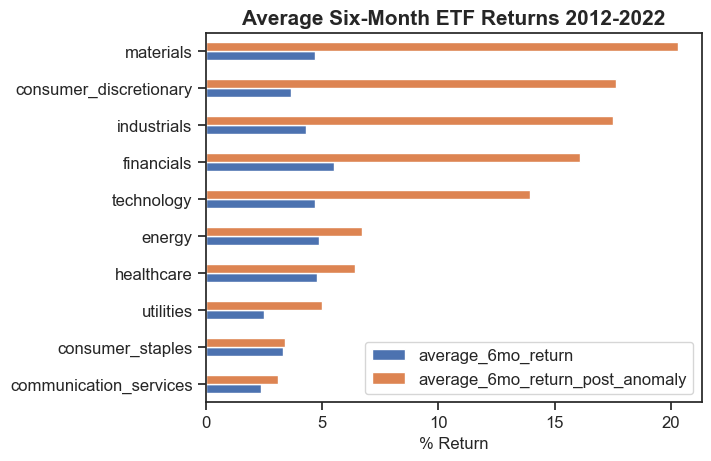

In [360]:
q2_deviations.sort_values(by='average_6mo_return_post_anomaly').plot.barh(y=['average_6mo_return',
                                                                                 'average_6mo_return_post_anomaly'], fontsize=12)
plt.title("Average Six-Month ETF Returns 2012-2022", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.xlabel("% Return", fontsize=12)
plt.show()

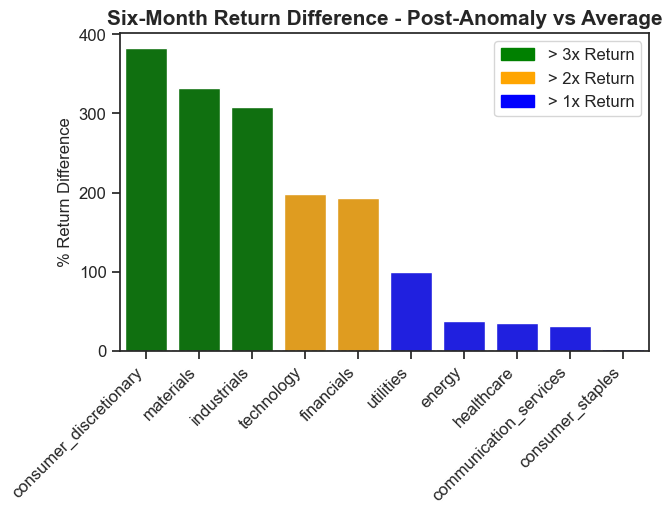

In [370]:
sorted_q2deviations = q2_deviations.sort_values(by='return_diff', ascending=False)

plt.figure(figsize=(7, 4))

color_palette = []
legend_info = []

for val in sorted_q2deviations['return_diff']:
    if val > 200:
        color = 'green'
        label = '> 3x Return'
    elif 100 <= val <= 200:
        color = 'orange'
        label = '> 2x Return'
    elif 0 <= val < 100:
        color = 'blue'
        label = '> 1x Return'
    else:
        color = 'red'
        label = 'Less Return'
    
    color_palette.append(color)
    legend_info.append((color, label))

sns.barplot(x=sorted_q2deviations.index, y=sorted_q2deviations['return_diff'], palette=color_palette)

unique_legend_info = list(set(legend_info))
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in unique_legend_info]

plt.legend(handles=legend_patches, fontsize=12, loc='upper right')
plt.tight_layout()
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.title("Six-Month Return Difference - Post-Anomaly vs Average", fontsize=15, fontweight='bold')
plt.ylabel("% Return Difference", fontsize=12)
plt.show()

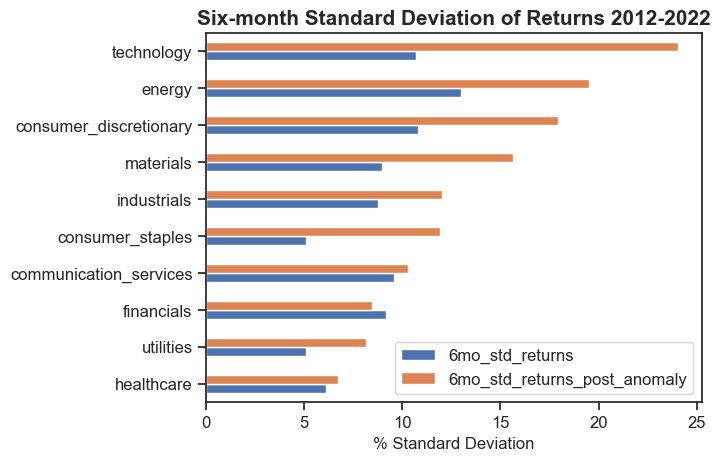

In [371]:
q2_deviations.sort_values(by='6mo_std_returns_post_anomaly').plot.barh(y=['6mo_std_returns',
                                                                                 '6mo_std_returns_post_anomaly'], fontsize=12)
plt.title("Six-month Standard Deviation of Returns 2012-2022", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.xlabel("% Standard Deviation", fontsize=12)
plt.show()

In [214]:
## counting number of anomalies on any specific date

from collections import defaultdict

date_counts = defaultdict(int)

for key, df in anomaly_dfs.items():
    dates = df.index.date.tolist()
    unique_dates = set(dates)
    
    for date in unique_dates:
        date_counts[date] += dates.count(date)

In [215]:
date_counts_df = pd.DataFrame.from_dict(date_counts, orient='index', columns=['count'])

In [216]:
date_counts_df.sort_values(by=['count'], ascending=False)

,count
2018-12-31,9
2020-03-31,8
2016-03-31,6
2020-06-30,4
2016-12-31,4
2018-09-30,4
2017-12-31,3
2015-09-30,3
2019-03-31,3
2021-12-31,2


<Axes: >

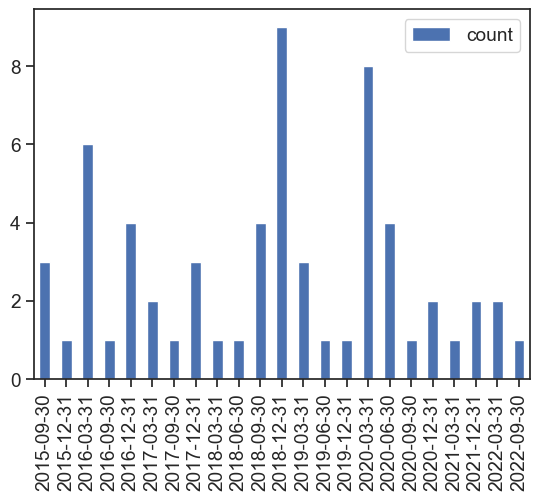

In [217]:
date_counts_df.sort_index().plot.bar()

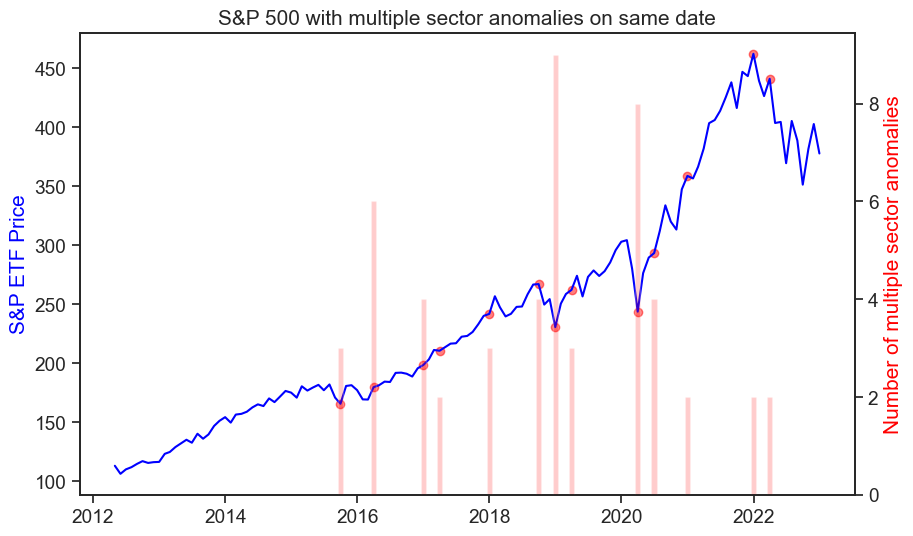

In [218]:
## looking at multiple sector anomaly effect on overall S&P500

filtered_dates = date_counts_df[date_counts_df['count'] > 1]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(tickers['s&p_500'].index, tickers['s&p_500']['close'], color='blue')
ax1.set_ylabel('S&P ETF Price', color='blue')

ax2 = ax1.twinx()
ax2.bar(filtered_dates.index, filtered_dates['count'], color='red', width=30, alpha=0.2)
ax2.set_ylabel('Number of multiple sector anomalies', color='red')

ax1.scatter(filtered_dates.index, tickers['s&p_500']['close'][filtered_dates.index], color='red', alpha=0.5)

ax1.set_title('S&P 500 with multiple sector anomalies on same date', fontsize=15)

plt.show()

## Conclusion
- A lot of anomalies are detected at turning points in price, but not all.
- On the whole, Returns, SD and Risk-Adjust Returns increased following an anomaly over the time periods analysed
- 6 months was the optimal holding period following an anomaly